In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, silhouette_score

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [4]:
char_df = pd.read_csv('data/dd_bios_02.csv', encoding='ISO-8859-1')

char_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3447 entries, 0 to 3446
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   timestamp            2447 non-null   object
 1   character_name       3447 non-null   object
 2   character_species    3447 non-null   object
 3   character_class      3447 non-null   object
 4   character_backstory  3343 non-null   object
dtypes: object(5)
memory usage: 134.8+ KB


In [5]:
char_df = char_df.drop(columns=['timestamp'])


In [6]:
char_df.head()

,character_name,character_species,character_class,character_backstory
0,Erryt,Aarakocra,Ranger,"Erryt, a 7 year-old Aarakocra with golden plum..."
1,Katyusha,Aarakocra,Cleric,Real name Erryt\n\nLives in fantasy Soviet Uni...
2,Surkiikri,Aarakocra,Monk,Surkiikri was firstborn of the ruling family o...
3,Azriel,Aasamar,Paladin,He was raised the isles in a family of nobles ...
4,Azophyr,Aasimar,Paladin,Hi... I'm Azophyr. I'm a fallen aasimar devoti...


In [7]:
char_df = char_df.dropna()

In [8]:
char_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3343 entries, 0 to 3446
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   character_name       3343 non-null   object
 1   character_species    3343 non-null   object
 2   character_class      3343 non-null   object
 3   character_backstory  3343 non-null   object
dtypes: object(4)
memory usage: 130.6+ KB


In [9]:
char_df.character_species.unique()

array(['Aarakocra', 'Aasamar', 'Aasimar', 'aasimar', 'Alien', 'Android',
       'Anthropomorphic Cockroach', 'Aquatic Half-Elf', 'Beeforged',
       'Birali (homebrew, sort of like a cat-folk)',
       'Birali turned back to Human', 'Birdfolk', 'Blue Dragonborn',
       'BugBear', 'Cambion', 'Catfolk', 'Catgirl', 'Celestial',
       'Changeling', 'Copper Dragonborn', 'Dark Elf', 'dark elf',
       'Dark elf', 'Dark Elf/Human', 'Deep Gnome', 'Demon', 'Dragonborn',
       'Drow', 'drow', 'Drow Elf', 'Drow elf', 'Dwarf', 'dwarf',
       'Earth Genasi', 'Eladrin', 'Elan', 'Elf', 'elf', 'Elf (Drow)',
       'Elf (Wood)', 'Fey Corgi', 'Feyblood', 'Fire genasi',
       'Forest gnome', 'Forest Gnome', 'genasi', 'Genasi',
       'Ghostwise Halfling', 'Ghoul Medusa', 'Githyanki', 'Gnoll',
       'Gnome', 'gnome', 'goblin', 'Goblin', 'Goliath', 'goliath',
       'Grey Elf', 'Hafling', 'Half Cat folk/ Half Elf', 'Half drow',
       "Half dwarf, half elf/orc (don't question it)", 'Half Elf',
      

In [10]:
# Convert all values in the 'character_species' and 'character_class' column to lowercase
char_df['character_species'] = char_df['character_species'].str.lower()
char_df['character_class'] = char_df['character_class'].str.lower()
char_df['character_name'] = char_df['character_name'].str.lower()
char_df['character_backstory'] = char_df['character_backstory'].str.lower()



# Verify the change
char_df['character_species'].unique()

array(['aarakocra', 'aasamar', 'aasimar', 'alien', 'android',
       'anthropomorphic cockroach', 'aquatic half-elf', 'beeforged',
       'birali (homebrew, sort of like a cat-folk)',
       'birali turned back to human', 'birdfolk', 'blue dragonborn',
       'bugbear', 'cambion', 'catfolk', 'catgirl', 'celestial',
       'changeling', 'copper dragonborn', 'dark elf', 'dark elf/human',
       'deep gnome', 'demon', 'dragonborn', 'drow', 'drow elf', 'dwarf',
       'earth genasi', 'eladrin', 'elan', 'elf', 'elf (drow)',
       'elf (wood)', 'fey corgi', 'feyblood', 'fire genasi',
       'forest gnome', 'genasi', 'ghostwise halfling', 'ghoul medusa',
       'githyanki', 'gnoll', 'gnome', 'goblin', 'goliath', 'grey elf',
       'hafling', 'half cat folk/ half elf', 'half drow',
       "half dwarf, half elf/orc (don't question it)", 'half elf',
       'half orc', 'half-dragon half-elf', 'half-drow',
       'half-dwarf / half-ogre', 'half-elf', 'half-elf (drow)',
       'half-orc', 'half-or

In [11]:
def replace_string_in_column(df, column, old_string, new_string):
    """
    Replaces occurrences of a specific string in a column with a new string.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column.
    column (str): The column name where the replacement should happen.
    old_string (str): The string to search for.
    new_string (str): The string to replace the old one with.

    Returns:
    pd.DataFrame: The DataFrame with the updated column.
    """
    df.loc[df[column].str.contains(old_string, case=False, na=False), column] = new_string
    return df

In [12]:
# We can clean up some glaring issues. There are still a lot of homebrew species, we will leave them as is. 

char_df = replace_string_in_column(char_df, 'character_species', 'aasamar', 'aasimar')
char_df = replace_string_in_column(char_df, 'character_species', 'half elf', 'half-elf')
char_df = replace_string_in_column(char_df, 'character_species', 'half drow', 'half-elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'half-drow', 'half-elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'half-ord', 'half-orc')
char_df = replace_string_in_column(char_df, 'character_species', 'drow', 'elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'drow elf', 'elf (drow)')
char_df = replace_string_in_column(char_df, 'character_species', 'humam', 'human')


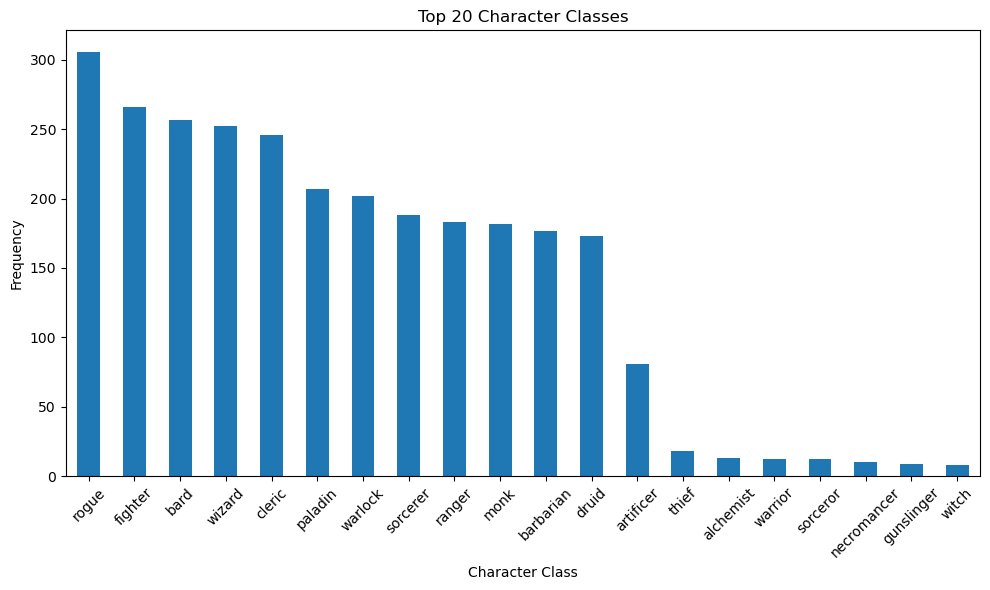

In [13]:
top_20_classes = char_df.character_class.value_counts().head(20)

# Create the plot
plt.figure(figsize=(10,6))
top_20_classes.plot(kind='bar')
plt.title('Top 20 Character Classes')
plt.xlabel('Character Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

This is a solid representation of the 5ed classes available, and a good number of other types of classes that make up this dataset. 

Let's start cleaning up the rest of the text to get ready for tokenization

In [14]:
# !pip install nltk

In [15]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# Make sure you have stopwords and lemmatizer from NLTK
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)
stop_words = set(stopwords.words('english'))

# Additional custom words to remove
custom_words = {"one", "would", "yet", "could", "though", "without", "like", "much"}
stop_words.update(custom_words)

lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dmm46\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dmm46\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
# Function to remove tokens that consist only of underscores
def clean_text(text):
    # Use regex to replace sequences of underscores with a space if they consist entirely of underscores
    return re.sub(r'\b_+\b', ' ', text)

In [17]:
# Preprocessing function: tokenization, lemmatization, and stopword removal
def preprocess_backstory(text):

    cleaned_text = clean_text(text)

    tokens = tokenizer.tokenize(cleaned_text.lower())  # Lowercase and tokenize
    
    # Remove stopwords first
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize the remaining tokens
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # Remove custom words and numbers
    final_tokens = [word for word in lemmatized_tokens if not re.search(r'\d', word) and word.isalpha()]
    
    return ' '.join(final_tokens)  # Join tokens back into a string


In [18]:
# Apply preprocessing to the character_backstory column
char_df['cleaned_backstory'] = char_df['character_backstory'].apply(preprocess_backstory)

In [19]:
char_df['cleaned_backstory'][10]

'backstory abaewin toredas life hard life born nybor leaving soon small town forest already unfamiliar surroundings descended fallen angel never truly fit life people ridiculed silver hair said grey abaewin parent never around always leaving device wander dark place realize dark place get peace quiet away people day saw woman wood seemed trying hide plain sight reason said hello jumped said see abaewin said mean dark trying hide woman responded mean dark barely see oh people descended fallen angel yes replied abaewin seem gotten anything gray hair woman said name zinnoara galantara might able teach thing two seem need guidance education abaewin responded parent around guess learn abaewin exactly street smart abaewin stayed zinnoara quite time hermited away wood wanted tasted power young child wanted freedom wanted parent died gone never found love parent understanding never home good people large group divs stormed town slaughtering whole thing divs evil knew abaewin parent peri abaewi

In [20]:
from collections import Counter

# Flatten all preprocessed backstories into one large list of words
all_words = ' '.join(char_df['cleaned_backstory']).split()

# Calculate word frequencies
word_freq = Counter(all_words)

In [21]:
sorted(word_freq)

['aaf',
 'aarackoan',
 'aarakocra',
 'aarakocran',
 'aaron',
 'aasimar',
 'aback',
 'abaewen',
 'abaewin',
 'abaivoi',
 'aballon',
 'abandon',
 'abandoned',
 'abandoning',
 'abandonment',
 'abated',
 'abato',
 'abbot',
 'abbott',
 'abby',
 'abbys',
 'abdication',
 'abducted',
 'abducting',
 'abel',
 'abernathy',
 'aberration',
 'aberrock',
 'abhorred',
 'abhorrent',
 'abhorring',
 'abhors',
 'abide',
 'abiding',
 'ability',
 'abject',
 'abjuration',
 'abjurer',
 'ablaze',
 'able',
 'abnormal',
 'aboard',
 'abode',
 'aboleth',
 'aboleths',
 'abolitionist',
 'abomination',
 'aborted',
 'abortive',
 'abound',
 'abounded',
 'abounding',
 'abrasive',
 'abrasiveness',
 'abraxas',
 'abraxos',
 'abres',
 'abridged',
 'abroad',
 'abrogail',
 'abrupt',
 'abruptly',
 'absalom',
 'absconded',
 'absence',
 'absent',
 'absentee',
 'absentism',
 'absentmindedly',
 'absolute',
 'absolutely',
 'absolution',
 'absolve',
 'absolved',
 'absorb',
 'absorbed',
 'absorbing',
 'absorbs',
 'abstalar',
 'abstra

The cleaned text looks better now after a few updated iterations of cleaning.

In [22]:
# Vectorize the cleaned backstories using TF-IDF
vectorizer = TfidfVectorizer()
vectored_backstory = vectorizer.fit_transform(char_df['cleaned_backstory'])

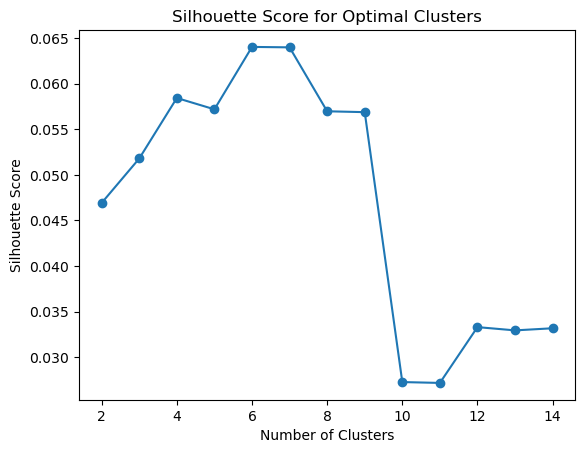

In [23]:
# Evaluate the Silhouette Score for different numbers of clusters
silhouette_scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(vectored_backstory)
    silhouette_scores.append(silhouette_score(vectored_backstory, labels))

# Plot the Silhouette Score
plt.plot(range(2, 15), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Clusters')
plt.show()

In [24]:
silhouette_scores

[0.046928577447044484,
 0.051799700072474544,
 0.05842745713565046,
 0.05718636131038318,
 0.0640270233207992,
 0.06397978196035746,
 0.05697199857767333,
 0.0568765099445584,
 0.027288363110701586,
 0.02719475176121043,
 0.03331161663857311,
 0.03295382208838105,
 0.033186652345159356]

In [25]:
max_value = max(silhouette_scores)
index_of_max = silhouette_scores.index(max_value)
index_of_max

4

Choose the number of clusters that yields the highest silhouette score.

In [26]:
# Use K-Means clustering to find themes
num_clusters = index_of_max+2  # Based on the silohuette score above. 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(vectored_backstory)

# Add the cluster labels as the theme category
char_df['backstory_cluster'] = kmeans.fit_predict(vectored_backstory)



In [27]:
# View the DataFrame with the new cluster labels
print(char_df[['character_name', 'character_species', 'character_class', 'backstory_cluster']])

           character_name character_species character_class  backstory_cluster
0                   erryt         aarakocra          ranger                  2
1                katyusha         aarakocra          cleric                  2
2               surkiikri         aarakocra            monk                  0
3                  azriel           aasimar         paladin                  0
4                 azophyr           aasimar         paladin                  2
...                   ...               ...             ...                ...
3442    seren oakenshield          plasmoid        sorcerer                  1
3443               lirael               elf            monk                  1
3444               aelric             owlin         fighter                  1
3445      bruni firebrand             dwarf          wizard                  4
3446  aelric shadowdancer           bugbear       barbarian                  1

[3343 rows x 4 columns]


In [28]:
char_df

,character_name,character_species,character_class,character_backstory,cleaned_backstory,backstory_cluster
0,erryt,aarakocra,ranger,"erryt, a 7 year-old aarakocra with golden plum...",erryt year old aarakocra golden plumage crest ...,2
1,katyusha,aarakocra,cleric,real name erryt\n\nlives in fantasy soviet uni...,real name erryt life fantasy soviet union vale...,2
2,surkiikri,aarakocra,monk,surkiikri was firstborn of the ruling family o...,surkiikri firstborn ruling family mistcliffs a...,0
3,azriel,aasimar,paladin,he was raised the isles in a family of nobles ...,raised isle family noble close tie god angelic...,0
4,azophyr,aasimar,paladin,hi... i'm azophyr. i'm a fallen aasimar devoti...,hi azophyr fallen aasimar devotion paladin enc...,2
...,...,...,...,...,...,...
3442,seren oakenshield,plasmoid,sorcerer,"cora is a plasmoid sorcerer, known for their u...",cora plasmoid sorcerer known unmatched skill b...,1
3443,lirael,elf,monk,"lirael stormhand is a elf monk, known for thei...",lirael stormhand elf monk known unmatched skil...,1
3444,aelric,owlin,fighter,"drake shadowdancer is a owlin fighter, known f...",drake shadowdancer owlin fighter known unmatch...,1
3445,bruni firebrand,dwarf,wizard,"durin spent their youth in dusty libraries, po...",durin spent youth dusty library poring ancient...,4


In [29]:
from collections import Counter

# Function to get word frequency for a cluster
def get_word_frequency(cluster_num):
    # Filter rows belonging to the specified cluster
    cluster_text = char_df[char_df['backstory_cluster'] == cluster_num]['cleaned_backstory']
    
    # Join all backstories in the cluster into a single string
    all_words = ' '.join(cluster_text).split()
    
    # Use Counter to get word frequencies
    word_freq = Counter(all_words)
    
    # Get the top 10 most common words in the cluster
    return word_freq.most_common(10)

# Loop over each cluster and get word frequencies
n_clusters = char_df['backstory_cluster'].nunique()  # Find the number of unique clusters

for cluster_num in range(n_clusters):
    print(f"\nCluster {cluster_num} - Top Words:")
    top_words = get_word_frequency(cluster_num)
    for word, freq in top_words:
        print(f"{word}: {freq}")


Cluster 0 - Top Words:
monastery: 124
home: 97
world: 71
left: 59
family: 50
monk: 49
find: 49
training: 49
way: 49
life: 47

Cluster 1 - Top Words:
known: 607
unmatched: 607
skill: 607
battle: 607
unwavering: 607
loyalty: 607
comrade: 607
journeyed: 607
far: 607
wide: 607

Cluster 2 - Top Words:
time: 1307
family: 1300
year: 1204
life: 1165
father: 1019
mother: 1002
day: 968
way: 896
found: 878
never: 803

Cluster 3 - Top Words:
ancient: 158
forest: 158
cora: 120
bryn: 80
raised: 79
nature: 79
time: 79
walk: 79
felt: 79
pulse: 79

Cluster 4 - Top Words:
darkest: 238
bryn: 218
cora: 198
shadow: 178
drake: 174
hand: 168
youth: 159
seek: 159
know: 159
heart: 158

Cluster 5 - Top Words:
power: 152
bryn: 88
never: 76
intended: 76
make: 76
pact: 76
force: 76
beyond: 76
world: 76
desperation: 76


______

To begin predicting on these clusters, we will need to turn the features into numerical data

_______

In [30]:
# Step 1: Encode categorical features (name, species, class) into numeric form
le_name = LabelEncoder()
le_species = LabelEncoder()
le_class = LabelEncoder()

char_df['encoded_name'] = le_name.fit_transform(char_df['character_name'])
char_df['encoded_species'] = le_species.fit_transform(char_df['character_species'])
char_df['encoded_class'] = le_class.fit_transform(char_df['character_class'])

In [31]:
# Features and target
X = char_df[['encoded_species', 'encoded_class']]
y = char_df['backstory_cluster']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Trying to balance my classes with some SMOTE

In [32]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

____

## Basic Machine Learning Shotgun Approach


____

In [33]:
# Define the models to try
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Classifier': SVC(),
    'Naive Bayes': MultinomialNB(),  # Naive Bayes often works well with categorical data
    'XGBoost': XGBClassifier()
}

In [34]:
# Step 4: Train and evaluate each model
for model_name, model in models.items():
    if model_name == 'Naive Bayes':
        # Use MinMaxScaler for MultinomialNB
        pipeline = Pipeline([
            ('scaler', MinMaxScaler()),  # Use MinMaxScaler for Naive Bayes to avoid negative values
            ('classifier', model)
        ])
    else:
        # Use StandardScaler for the other models
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Use StandardScaler for other models
            ('classifier', model)
        ])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = pipeline.predict(X_test)
    
    # Classification report
    print(f"Results for {model_name}:")
    print(classification_report(y_test, y_pred, zero_division=0))

Results for Random Forest:
              precision    recall  f1-score   support

           0       0.07      0.02      0.03        52
           1       0.64      0.57      0.60       108
           2       0.78      0.87      0.82       440
           3       0.71      0.71      0.71        14
           4       0.76      0.76      0.76        42
           5       0.73      0.85      0.79        13

    accuracy                           0.74       669
   macro avg       0.62      0.63      0.62       669
weighted avg       0.70      0.74      0.72       669

Results for Logistic Regression:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.00      0.00      0.00       108
           2       0.66      1.00      0.79       440
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        42
           5       0.00      0.00      0.00        13

    accuracy     

____

Random Forest turned out the best initial accuracy, a very low 42%. Let's try and improve on that.\
XGBoost gave us 44%

UPDATE:\
After doing some more prepocessing of the text to remove some more dirty data and stopwords we are getting better accuracy out of the gate.\
Random Forest is giving 74%\
XGBoost is giving 78%

_____

In [35]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10]
# }

# rf = RandomForestClassifier(class_weight='balanced', random_state=42)
# grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# best_rf = grid_search.best_estimator_
# y_pred = best_rf.predict(X_test)

# print(f"Best Parameters: {grid_search.best_params_}")
# print(classification_report(y_test, y_pred))

Best Parameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 300}
              precision    recall  f1-score   support

           0       0.13      0.13      0.13        52
           1       0.58      0.65      0.61       108
           2       0.80      0.71      0.75       440
           3       0.48      0.79      0.59        14
           4       0.65      0.81      0.72        42
           5       0.38      0.92      0.53        13

    accuracy                           0.67       669
   macro avg       0.50      0.67      0.56       669
weighted avg       0.69      0.67      0.67       669



____

grid search made it worse!

____

In [36]:
# model = RandomForestClassifier(class_weight='balanced', random_state=42)
# scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
# print(f"Mean accuracy: {scores.mean()}")

Mean accuracy: 0.6562968233935716


Using the voting classifier, we can use mulitple models together. 

In [37]:
from sklearn.ensemble import VotingClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Apply scaling
    ('classifier', LogisticRegression(solver='saga', max_iter=500, random_state=42))
])

model1 = RandomForestClassifier(class_weight='balanced', random_state=42)
# model2 = LogisticRegression(max_iter=500, random_state=42)
model3 = SVC(probability=True, class_weight='balanced', random_state=42)
model4 = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

ensemble_model = VotingClassifier(estimators=[
    ('rf', model1), ('lr', pipeline), ('svc', model3), ('xgb', model4)],
    voting='soft')

ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

c:\Users\dmm46\miniconda3\envs\tf-gpu\lib\site-packages\xgboost\core.py:158: UserWarning: [11:06:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        52
           1       0.82      0.56      0.67       108
           2       0.77      0.95      0.86       440
           3       0.83      0.71      0.77        14
           4       0.85      0.55      0.67        42
           5       0.77      0.77      0.77        13

    accuracy                           0.78       669
   macro avg       0.68      0.59      0.62       669
weighted avg       0.73      0.78      0.74       669



___

We are up to 45%, not really amazing at all.\ 
Added xgboost and got to 47%. There are a lot of zeroed out classes here. 

UPDATE:\
Again, we have better accuracy out of the gate. We are look at 78% with better f-scores overall than previously

____

________
## Neural Net Work
______

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

texts = char_df['cleaned_backstory'].tolist()

_____

In [42]:
# Tokenize and prepare data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
vocab_size = len(tokenizer.word_index) + 1

# Convert texts to sequences of word indices
sequences = tokenizer.texts_to_sequences(texts)

# Define max_len (adjustable)
max_len = 100

# Generator function to yield batches of data
def data_generator(sequences, batch_size, max_len, vocab_size):
    num_samples = len(sequences)
    while True:
        for offset in range(0, num_samples, batch_size):
            # Create a batch of input sequences (X) and target sequences (y)
            X_batch = [seq[:-1] for seq in sequences[offset:offset + batch_size]]
            y_batch = [seq[1:] for seq in sequences[offset:offset + batch_size]]
            
            # Pad sequences to max_len
            X_batch = pad_sequences(X_batch, maxlen=max_len, padding='post')
            y_batch = pad_sequences(y_batch, maxlen=max_len, padding='post')
            
            # Convert to float32 to reduce memory usage
            X_batch = X_batch.astype('float32')
            y_batch = np.array([np.eye(vocab_size)[seq] for seq in y_batch], dtype='float32')
            
            yield [X_batch, X_batch], y_batch  # Yield inputs and targets as a tuple

# Model definition
embedding_dim = 64
latent_dim = 128 # reducing this from 256 since data set isn't super large. 

# Encoder
encoder_inputs = Input(shape=(max_len,))
encoder_embedding = Embedding(vocab_size, embedding_dim, input_length=max_len)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True, dropout=0.2) # adding dropouts to help with overfitting
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding) # get the hidden state and cell state
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_len,))
decoder_embedding = Embedding(vocab_size, embedding_dim, input_length=max_len)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the full model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set batch size and number of steps per epoch
batch_size = 16
steps_per_epoch = len(sequences) // batch_size



In [43]:
# Train the model using the updated `fit` method
model.fit(data_generator(sequences, batch_size, max_len, vocab_size), 
          steps_per_epoch=steps_per_epoch, epochs=50)

Epoch 1/50
208/208 [==============================] - 183s 859ms/step - loss: 4.9802 - accuracy: 0.4999
Epoch 2/50
208/208 [==============================] - 178s 856ms/step - loss: 3.8846 - accuracy: 0.5029
Epoch 3/50
208/208 [==============================] - 159s 765ms/step - loss: 3.7774 - accuracy: 0.5053
Epoch 4/50
208/208 [==============================] - 155s 747ms/step - loss: 3.7013 - accuracy: 0.5114
Epoch 5/50
208/208 [==============================] - 157s 755ms/step - loss: 3.6470 - accuracy: 0.5172
Epoch 6/50
208/208 [==============================] - 153s 736ms/step - loss: 3.5688 - accuracy: 0.5339
Epoch 7/50
208/208 [==============================] - 152s 733ms/step - loss: 3.4748 - accuracy: 0.5493
Epoch 8/50
208/208 [==============================] - 153s 733ms/step - loss: 3.3816 - accuracy: 0.5620
Epoch 9/50
208/208 [==============================] - 152s 733ms/step - loss: 3.2874 - accuracy: 0.5710
Epoch 10/50
208/208 [==============================] - 153s 735m

In [37]:
# # Save the model after training
# model.save('seq2seq_model.h5')

In [44]:
# Save the model after training
model.save('seq2seq_new_clean_model.h5')

In [38]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('seq2seq_new_clean_model.h5')

In [39]:
# # Resume training from where it left off
# model.fit(data_generator(sequences, batch_size, max_len, vocab_size), 
#           steps_per_epoch=steps_per_epoch, epochs=50)

In [40]:
# from tensorflow.keras.optimizers import Adam

# # Lower the learning rate to fine-tune
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# # Continue training
# model.fit(data_generator(sequences, batch_size, max_len, vocab_size), 
#           steps_per_epoch=steps_per_epoch, epochs=50)

In [45]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 100, 64)      1505216     ['input_6[0][0]']                
                                                                                                  
 embedding_6 (Embedding)        (None, 100, 64)      1505216     ['input_7[0][0]']                
                                                                                            

In [51]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Create a callback to save the model after each epoch
checkpoint = ModelCheckpoint('seq2seq_checkpoint.h5', save_best_only=True, monitor='loss', mode='min')

# Train the model with the checkpoint callback
model.fit(data_generator(sequences, batch_size, max_len, vocab_size), 
          steps_per_epoch=steps_per_epoch, epochs=50, callbacks=[checkpoint])

Epoch 1/50
208/208 [==============================] - 190s 910ms/step - loss: 1.8021 - accuracy: 0.6947
Epoch 2/50
208/208 [==============================] - 192s 926ms/step - loss: 1.7813 - accuracy: 0.6973
Epoch 3/50
208/208 [==============================] - 204s 983ms/step - loss: 1.7570 - accuracy: 0.7000
Epoch 4/50
208/208 [==============================] - 284s 1s/step - loss: 1.7434 - accuracy: 0.7015
Epoch 5/50
208/208 [==============================] - 180s 868ms/step - loss: 1.7239 - accuracy: 0.7046
Epoch 6/50
208/208 [==============================] - 175s 843ms/step - loss: 1.6965 - accuracy: 0.7083
Epoch 7/50
208/208 [==============================] - 176s 851ms/step - loss: 1.6712 - accuracy: 0.7115
Epoch 8/50
208/208 [==============================] - 174s 839ms/step - loss: 1.6488 - accuracy: 0.7146
Epoch 9/50
208/208 [==============================] - 174s 841ms/step - loss: 1.6294 - accuracy: 0.7170
Epoch 10/50
208/208 [==============================] - 175s 845ms/s

In [52]:
# # Save the model after training
# model.save('seq2seq_02_model.h5')

In [46]:
# Step 1: Define inference models

# Encoder model for inference
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder model for inference
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Retrieve the correct embedding layer for the decoder ('embedding_6')
decoder_embedding_layer = model.get_layer('embedding_6')  # Use the correct decoder embedding layer name
decoder_inputs_inf = Input(shape=(1,))  # One word at a time
decoder_embedding_inf = decoder_embedding_layer(decoder_inputs_inf)

# Decoder LSTM (for inference, one word at a time)
decoder_lstm_inf, state_h_inf, state_c_inf = decoder_lstm(decoder_embedding_inf, initial_state=decoder_states_inputs)
decoder_states_inf = [state_h_inf, state_c_inf]

# Dense layer to generate the next word
decoder_outputs_inf = decoder_dense(decoder_lstm_inf)

# Define the decoder model for inference
decoder_model = Model([decoder_inputs_inf] + decoder_states_inputs, [decoder_outputs_inf] + decoder_states_inf)

In [47]:
decoder_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_6 (Embedding)        multiple             1505216     ['input_10[0][0]']               
                                                                                                  
 input_8 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 128)]        0           []                               
                                                                                            

In [48]:
encoder_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 100, 64)           1505216   
                                                                 
 lstm_4 (LSTM)               [(None, 128),             98816     
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
Total params: 1,604,032
Trainable params: 1,604,032
Non-trainable params: 0
_________________________________________________________________


In [45]:
# !pip install pydot

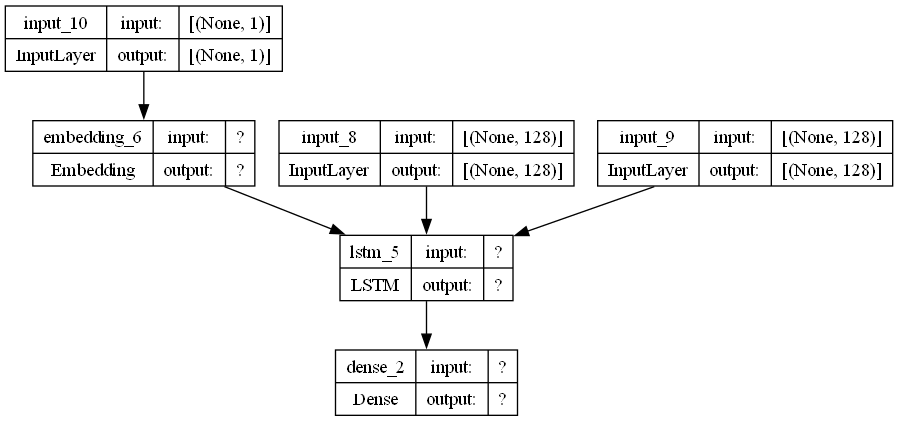

In [49]:
from tensorflow.keras.utils import plot_model
plot_model(decoder_model, to_file='decoder_model.png', show_shapes=True, show_layer_names=True)

In [59]:
# Adding a temperature parameter

def sample_with_temperature(predictions, temperature=0.7):
    predictions = np.asarray(predictions).astype('float64')
    predictions = np.log(predictions + 1e-8) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    return np.random.choice(range(len(predictions)), p=predictions)

In [60]:
def generate_text(input_seq, tokenizer, max_len, temperature=1.0):
    # Encode the input sequence to get the initial state
    states_value = encoder_model.predict(input_seq)

    # Prepare the target sequence (start with the "start" token or first word)
    target_seq = np.zeros((1, 1))  # Decoder input starts with a single token
    target_seq[0, 0] = tokenizer.word_index.get('start', 1)  # Use 'start' token or default token

    # Initialize the output sequence
    stop_condition = False
    generated_text = []
    
    while not stop_condition:
        # Predict the next word using decoder model
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample the next word using temperature-based sampling
        sampled_token_index = sample_with_temperature(output_tokens[0, -1, :], temperature)
        sampled_word = tokenizer.index_word.get(sampled_token_index, '')

        # Add the word to the generated text
        generated_text.append(sampled_word)

        # Stop if 'end' token is predicted or sequence is too long
        if sampled_word == 'end' or len(generated_text) >= max_len:
            stop_condition = True

        # Update the target sequence (shift the word) and update states
        target_seq = np.zeros((1, 1))  # Prepare for the next word
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return ' '.join(generated_text)

In [61]:
sample_sentence = texts[10]

first_four_words = ' '.join(sample_sentence.split()[:4])

first_four_words

'backstory abaewin toredas life'

In [62]:
sample_sentence

'backstory abaewin toredas life hard life born nybor leaving soon small town forest already unfamiliar surroundings descended fallen angel never truly fit life people ridiculed silver hair said grey abaewin parent never around always leaving device wander dark place realize dark place get peace quiet away people day saw woman wood seemed trying hide plain sight reason said hello jumped said see abaewin said mean dark trying hide woman responded mean dark barely see oh people descended fallen angel yes replied abaewin seem gotten anything gray hair woman said name zinnoara galantara might able teach thing two seem need guidance education abaewin responded parent around guess learn abaewin exactly street smart abaewin stayed zinnoara quite time hermited away wood wanted tasted power young child wanted freedom wanted parent died gone never found love parent understanding never home good people large group divs stormed town slaughtering whole thing divs evil knew abaewin parent peri abaewi

In [67]:
# Test generation with a seed sequence
seed_text = first_four_words  # Use a starting text from your data
seed_sequence = tokenizer.texts_to_sequences([seed_text])
seed_sequence = pad_sequences(seed_sequence, maxlen=max_len, padding='post')

In [73]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\dmm46\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


True

In [74]:
import random

# List of filler words categorized by parts of speech
filler_words_by_pos = {
    'NN': ['the', 'a', 'some'],    # Insert articles before nouns
    'VB': ['is', 'was', 'has'],    # Insert auxiliary verbs before verbs
    'JJ': ['very', 'quite', 'rather'],  # Insert intensifiers before adjectives
    'IN': ['with', 'by', 'on'],   # Insert prepositions after certain phrases
}

# Function to intelligently add filler words using POS tagging
def add_filler_words_smart(generated_text, filler_words_by_pos, insertion_prob=0.3):
    words = nltk.word_tokenize(generated_text)  # Tokenize the text
    pos_tags = nltk.pos_tag(words)  # Get POS tags for the generated text
    new_text = []
    
    for word, pos in pos_tags:
        new_text.append(word)
        
        # If the word's POS is in our filler_words_by_pos dictionary, insert a filler word
        if pos in filler_words_by_pos and random.random() < insertion_prob:
            filler_word = random.choice(filler_words_by_pos[pos])
            new_text.append(filler_word)
    
    return ' '.join(new_text)



In [80]:
# Function to generate structured sentences using POS tagging on enhanced text
def generate_structured_text(enhanced_text, max_sent_len=10):
    words = nltk.word_tokenize(enhanced_text)  # Tokenize the text into words
    pos_tags = nltk.pos_tag(words)  # Get POS tags for the words
    
    generated_sentences = []
    current_sentence = []

    # Iterate through the POS tagged words and structure sentences
    for word, pos in pos_tags:
        current_sentence.append(word)
        
        # Define basic sentence-ending logic based on POS
        # End the sentence if a noun, verb, or adjective has been seen and sentence is long enough
        if pos in ('NN', 'VB', 'JJ') and len(current_sentence) >= max_sent_len:
            generated_sentences.append(' '.join(current_sentence))
            current_sentence = []
    
    # Add any remaining words as the last sentence
    if current_sentence:
        generated_sentences.append(' '.join(current_sentence))

    # Join the sentences with punctuation
    punctuated_text = '. '.join(generated_sentences) + '.'
    
    return punctuated_text


In [81]:
# Example usage after generating text
generated_text = generate_text(seed_sequence, tokenizer, max_len)

# Generate the enhanced text by inserting filler words based on POS tags
enhanced_text = add_filler_words_smart(generated_text, filler_words_by_pos)

punctuatated_text = generate_structured_text(enhanced_text)

print("Generated text with smart fillers:", punctuatated_text)

1/1 [==============================] - 0s 18ms/step
Generated text with smart fillers: queen rather never pretending noise rate started skin a found. wear wave some punched poor klaetus stopped figure best enough find something. sure quite despite shown god punched ashamed reputation some prison. some non often totally sense debt actively going place determine. curse the needed view world realise regarding wisdom particularly lessened desperately currently hook. trust stood man remain remains mad rather earning name a person. money despite guess began get song introduced natured first intention. suffering possible add seat slew took recognize face skill fault. around future very almost seemed work embracing time the family. even friend rather since by day a mother dad childhood. name a feel redemption some way adventurer a also goal.


We are getting better text, but it is still a bit odd. One example:

Generated text with smart fillers: queen rather never pretending noise rate started skin a found. wear wave some punched poor klaetus stopped figure best enough find something. sure quite despite shown god punched ashamed reputation some prison. some non often totally sense debt actively going place determine. curse the needed view world realise regarding wisdom particularly lessened desperately currently hook. trust stood man remain remains mad rather earning name a person. money despite guess began get song introduced natured first intention. suffering possible add seat slew took recognize face skill fault. around future very almost seemed work embracing time the family. even friend rather since by day a mother dad childhood. name a feel redemption some way adventurer a also goal.

Let's incorporate gpt2 to enchance the generated text.

In [82]:
!pip install transformers


In [83]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Function to refine text using GPT-2
def refine_with_gpt2(text, max_length=100):
    inputs = tokenizer.encode(text, return_tensors='pt')

    # Generate text using GPT-2
    outputs = model.generate(
        inputs,
        max_length=max_length,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        repetition_penalty=1.2,
        top_p=0.95,
        temperature=0.7,
        do_sample=True
    )

    # Decode the generated text
    refined_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return refined_text

# Example usage with the generated text
generated_text = punctuatated_text
refined_text = refine_with_gpt2(generated_text)

print("Refined text:", refined_text)

c:\Users\dmm46\miniconda3\envs\tf-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


OSError: [WinError 127] The specified procedure could not be found. Error loading "c:\Users\dmm46\miniconda3\envs\tf-gpu\lib\site-packages\torch\lib\shm.dll" or one of its dependencies.